# **1.Connection avec Google Drive**







In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **2.Installer les bibliothèques recommandées**


In [ ]:
# Copier le fichier requirements.txt dans le système de fichiers du Colab en spécifiant un chemin de destination
!cp "/content/drive/MyDrive/Colab_Notebooks/requirements.txt" .


In [ ]:
# Installer les bibliothèques à partir du fichier requirements.txt
!pip install -r requirements.txt

  Using cached jupyter-1.0.0-py2.py3-none-any.whl (2.7 kB)
  Using cached opencv_contrib_python-4.9.0.80-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (68.3 MB)
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 13.1 MB/s eta 0:00:00


# **3.Importation des bibliothèques nécessaires**

In [ ]:
from keras.utils import to_categorical
from keras_preprocessing.image import load_img
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
from keras.models import model_from_json
from sklearn.preprocessing import LabelEncoder
from tqdm.notebook import tqdm
import zipfile
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# **4.Définir les chemins des répertoires**

In [ ]:
# Définir les chemins des répertoires pour les ensembles d'images d'entraînement et de validation
TRAIN_DIR = '/content/images/train'    # Chemin vers le répertoire contenant les images d'entraînement
TEST_DIR = '/content/images/validation' # Chemin vers le répertoire contenant les images de validation

# **5.Téléchargement et extraction du jeu de données**

In [ ]:
# Chemin vers le fichier zip téléchargé
zip_file_path = "/content/drive/MyDrive/Colab_Notebooks/archive.zip"

# Répertoire où extraire le jeu de données
extracted_dir = "/content"

# Extraire le fichier zip
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir)


# **6.Fonction pour créer un DataFrame à partir des images**

In [ ]:
# Fonction pour créer des listes de chemins d'images et d'étiquettes à partir d'un répertoire donné
def createdataframe(dir):
    image_paths = []  # Liste pour stocker les chemins des images
    labels = []       # Liste pour stocker les étiquettes des images

    # Parcourir chaque sous-répertoire (étiquette) dans le répertoire principal
    for label in os.listdir(dir):

        # Parcourir chaque fichier image dans le sous-répertoire de l'étiquette
        for imagename in os.listdir(os.path.join(dir, label)):
            # Ajouter le chemin complet de l'image à la liste des chemins
            image_paths.append(os.path.join(dir, label, imagename))
            # Ajouter l'étiquette correspondante à la liste des étiquettes
            labels.append(label)

        # Indiquer que toutes les images de cette étiquette ont été traitées
        print(label, "completed")

    # Retourner les listes des chemins d'images et des étiquettes
    return image_paths, labels


# **7.Création du DataFrame pour les données d'entraînement et de validation**

In [ ]:
# Créer un DataFrame vide
train = pd.DataFrame()

# Appeler la fonction createdataframe pour obtenir les chemins des images et les étiquettes à partir de TRAIN_DIR
train['image'], train['label'] = createdataframe(TRAIN_DIR)  # Assigner les chemins des images à la colonne 'image' et les étiquettes à la colonne 'label' du DataFrame


disgust completed
fear completed
neutral completed
angry completed
happy completed
sad completed
surprise completed


In [ ]:
test = pd.DataFrame()
test['image'], test['label'] = createdataframe(TEST_DIR)

disgust completed
fear completed
neutral completed
angry completed
happy completed
sad completed
surprise completed


# **8.Extraction des caractéristiques des images**

In [ ]:
# Fonction pour extraire les caractéristiques des images
def extract_features(images):
    features = []  # Liste pour stocker les caractéristiques des images

    # Parcourir chaque image avec une barre de progression
    for image in tqdm(images):
        # Charger l'image en niveaux de gris
        img = load_img(image, color_mode='grayscale')

        # Convertir l'image en tableau NumPy
        img = np.array(img)

        # Ajouter l'image (sous forme de tableau) à la liste des caractéristiques
        features.append(img)

    # Convertir la liste en tableau NumPy
    features = np.array(features)

    # Redimensionner le tableau pour qu'il ait la forme (nombre d'images, 48, 48, 1)
    features = features.reshape(len(features), 48, 48, 1)

    # Retourner le tableau des caractéristiques
    return features


In [ ]:
# Extraire les caractéristiques des images d'entraînement
# La fonction extract_features est appelée avec la colonne 'image' du DataFrame train
# Les caractéristiques extraites sont stockées dans la variable train_features
train_features = extract_features(train['image'])

  0%|          | 0/28821 [00:00<?, ?it/s]

In [ ]:
# Extraire les caractéristiques des images de test
# La fonction extract_features est appelée avec la colonne 'image' du DataFrame test
# Les caractéristiques extraites sont stockées dans la variable test_features
test_features = extract_features(test['image'])


  0%|          | 0/7066 [00:00<?, ?it/s]

# **9.Normalisation des caractéristiques et encodage des étiquettes**

In [ ]:
# Normaliser les caractéristiques des images d'entraînement en divisant chaque pixel par 255.0,
# cela permet de mettre les valeurs des pixels dans la plage [0,1]
x_train = train_features / 255.0

# Normaliser les caractéristiques des images de test de la même manière
x_test = test_features / 255.0


In [ ]:
# Créer une instance de LabelEncoder pour encoder les étiquettes des classes
le = LabelEncoder()

# Adapter l'encodeur aux étiquettes de la colonne 'label' du DataFrame train
le.fit(train['label'])


LabelEncoder()

In [ ]:
# Utiliser l'encodeur de labels pour transformer les étiquettes de classe en valeurs numériques pour les données d'entraînement
y_train = le.transform(train['label'])

# Utiliser l'encodeur de labels pour transformer les étiquettes de classe en valeurs numériques pour les données de test
y_test = le.transform(test['label'])


In [ ]:
# Convertir les étiquettes numériques d'entraînement en vecteurs binaires
# avec une dimension égale au nombre de classes (7 dans cet exemple)
y_train = to_categorical(y_train, num_classes=7)

# Convertir les étiquettes numériques de test en vecteurs binaires
# avec une dimension égale au nombre de classes (7 dans cet exemple)
y_test = to_categorical(y_test, num_classes=7)


# **10.Construction du modèle CNN**

In [ ]:
# Création d'un modèle séquentiel
model = Sequential()

# Première couche de convolution avec 128 filtres, taille de noyau 3x3, fonction d'activation ReLU
model.add(Conv2D(128, kernel_size=(3,3), activation='relu', input_shape=(48,48,1)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

# Deuxième couche de convolution avec 256 filtres, taille de noyau 3x3, fonction d'activation ReLU
model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

# Troisième couche de convolution avec 512 filtres, taille de noyau 3x3, fonction d'activation ReLU
model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

# Quatrième couche de convolution avec 512 filtres, taille de noyau 3x3, fonction d'activation ReLU
model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

# Aplatir les données pour les couches entièrement connectées
model.add(Flatten())

# Première couche entièrement connectée avec 512 neurones, fonction d'activation ReLU
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))

# Deuxième couche entièrement connectée avec 256 neurones, fonction d'activation ReLU
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))

# Couche de sortie avec 7 neurones pour les 7 classes, fonction d'activation softmax
model.add(Dense(7, activation='softmax'))


# **11.Compilation du modèle**

In [ ]:
# Compilation du modèle avec l'optimiseur Adam
# La fonction de perte est categorical_crossentropy
# La métrique utilisée pour évaluer le modèle est l'accuracy
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


# **12.Entrainement du modèle**

In [ ]:
# Entraînement du modèle sur les données d'entraînement avec un batch_size de 128 et 40 époques
# Les données de validation sont fournies pour évaluer le modèle pendant l'entraînement
history = model.fit(x=x_train, y=y_train, batch_size=128, epochs=40, validation_data=(x_test, y_test))


Epoch 1/40
226/226 [==============================] - 79s 343ms/step - loss: 1.8231 - accuracy: 0.2434 - val_loss: 1.8209 - val_accuracy: 0.2583
Epoch 2/40
226/226 [==============================] - 76s 338ms/step - loss: 1.8025 - accuracy: 0.2495 - val_loss: 1.7725 - val_accuracy: 0.2584
Epoch 3/40
226/226 [==============================] - 76s 338ms/step - loss: 1.7370 - accuracy: 0.2830 - val_loss: 1.7106 - val_accuracy: 0.3177
Epoch 4/40
226/226 [==============================] - 76s 338ms/step - loss: 1.6270 - accuracy: 0.3497 - val_loss: 1.4567 - val_accuracy: 0.4391
Epoch 5/40
226/226 [==============================] - 76s 336ms/step - loss: 1.5081 - accuracy: 0.4100 - val_loss: 1.3743 - val_accuracy: 0.4718
Epoch 6/40
226/226 [==============================] - 75s 334ms/step - loss: 1.4441 - accuracy: 0.4412 - val_loss: 1.3099 - val_accuracy: 0.4987
Epoch 7/40
226/226 [==============================] - 76s 334ms/step - loss: 1.4012 - accuracy: 0.4620 - val_loss: 1.2896 - val_ac

# **13.Sauvegarde du modèle**

In [ ]:
# Convertir l'architecture du modèle en format JSON
model_json = model.to_json()

# Écrire l'architecture du modèle JSON dans un fichier
with open("emotiondetector_40_epochs.json", 'w') as json_file:
    json_file.write(model_json)

# Sauvegarder les poids du modèle dans un fichier h5
model.save("emotiondetector_40_epochs.h5")


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Ouvrir le fichier JSON contenant l'architecture du modèle en mode lecture
json_file = open("emotiondetector_40_epochs.json", "r")

# Lire le contenu du fichier JSON
model_json = json_file.read()

# Fermer le fichier JSON après lecture
json_file.close()

# Charger l'architecture du modèle à partir du JSON
model = model_from_json(model_json)

# Charger les poids du modèle à partir du fichier h5
model.load_weights("emotiondetector_40_epochs.h5")


In [ ]:
# Liste des noms d'émotions correspondant aux classes prédites par le modèle
label = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [ ]:
# Définition de la fonction pour extraire les caractéristiques d'une image ef = extract features
def ef(image):
    # Charger l'image en niveaux de gris
    img = load_img(image, grayscale=True)

    # Convertir l'image en tableau NumPy
    feature = np.array(img)

    # Redimensionner le tableau pour correspondre à la forme attendue par le modèle (1, 48, 48, 1)
    feature = feature.reshape(1, 48, 48, 1)

    # Normaliser les caractéristiques en divisant par 255.0 pour mettre les valeurs des pixels dans la plage [0,1]
    return feature / 255.0


# **14.Utilisation du modèle pour prédire l'émotion d'une image spécifique**

In [ ]:
# Chemin de l'image à tester
image = '/content/images/train/fear/10047.jpg'

# Affichage de l'émotion originale de l'image (dans ce cas, c'est 'fear')
print("L'image originale est de type fear")

# Utilisation de la fonction ef pour extraire les caractéristiques de l'image
img = ef(image)

# Prédiction de l'émotion de l'image à l'aide du modèle
pred = model.predict(img)

# Récupération de l'indice de la classe prédite avec la plus haute probabilité
pred_label = label[pred.argmax()]

# Affichage de la prédiction du modèle
print("La prédiction du modèle est :", pred_label)


L'image originale est de type fear
1/1 [==============================] - 0s 126ms/step
La prédiction du modèle est : fear


/usr/local/lib/python3.10/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [ ]:
%matplotlib inline

original image is of fear
1/1 [==============================] - 0s 26ms/step
model prediction is  fear


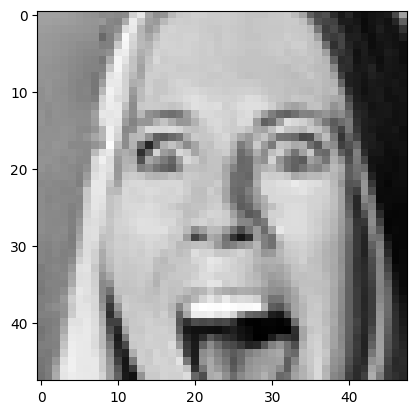

In [ ]:
image = '/content/images/train/fear/10047.jpg'
print("original image is of fear")
img = ef(image)
pred = model.predict(img)
pred_label = label[pred.argmax()]
print("model prediction is ",pred_label)
plt.imshow(img.reshape(48,48),cmap='gray')

original image is of disgust
1/1 [==============================] - 0s 26ms/step
model prediction is  angry


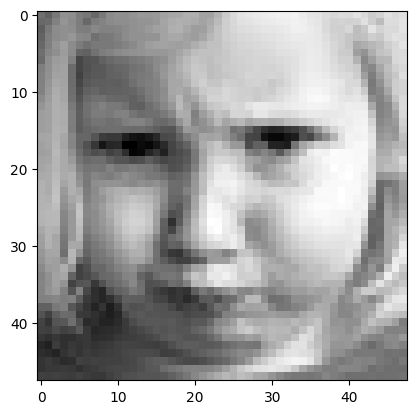

In [ ]:
image = '/content/images/train/disgust/10137.jpg'
print("original image is of disgust")
img = ef(image)
pred = model.predict(img)
pred_label = label[pred.argmax()]
print("model prediction is ",pred_label)
plt.imshow(img.reshape(48,48),cmap='gray')

original image is of happy
1/1 [==============================] - 0s 27ms/step
model prediction is  happy


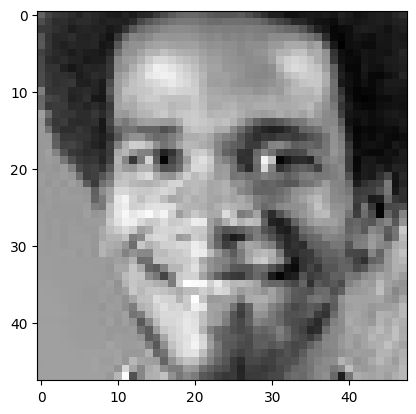

In [ ]:
image = '/content/images/train/happy/10418.jpg'
print("original image is of happy")
img = ef(image)
pred = model.predict(img)
pred_label = label[pred.argmax()]
print("model prediction is ",pred_label)
plt.imshow(img.reshape(48,48),cmap='gray')

original image is of surprise
1/1 [==============================] - 0s 27ms/step
model prediction is  surprise


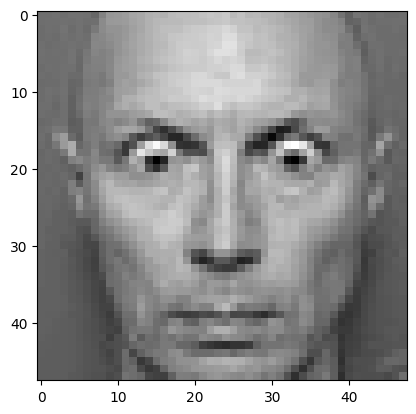

In [ ]:
image = 'images/train/surprise/15.jpg'
print("original image is of surprise")
img = ef(image)
pred = model.predict(img)
pred_label = label[pred.argmax()]
print("model prediction is ",pred_label)
plt.imshow(img.reshape(48,48),cmap='gray')

# **15.Extraire les données de l'historique**

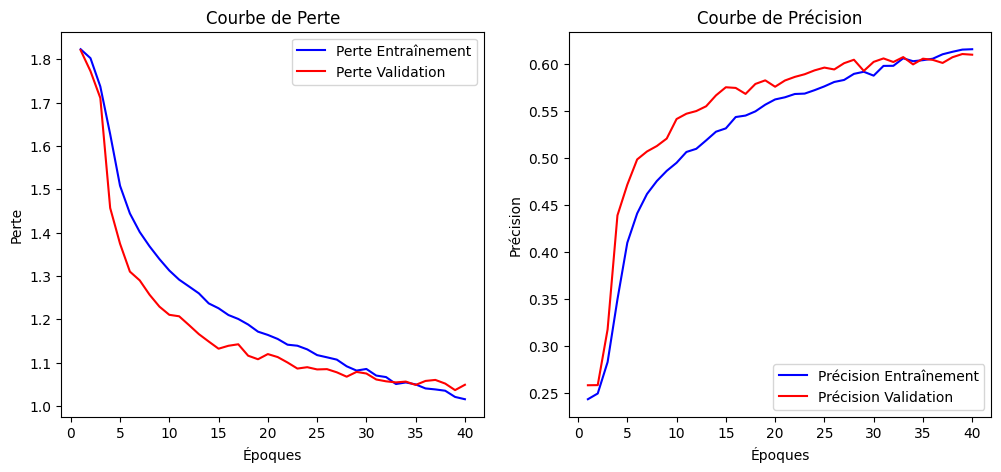

In [ ]:
# Extraire les données de l'historique
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Créer les graphiques
epochs = range(1, len(train_loss) + 1)

# Tracer la courbe de perte
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b', label='Perte Entraînement')
plt.plot(epochs, val_loss, 'r', label='Perte Validation')
plt.title('Courbe de Perte')
plt.xlabel('Époques')
plt.ylabel('Perte')
plt.legend()

# Tracer la courbe de précision
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'b', label='Précision Entraînement')
plt.plot(epochs, val_accuracy, 'r', label='Précision Validation')
plt.title('Courbe de Précision')
plt.xlabel('Époques')
plt.ylabel('Précision')
plt.legend()

plt.show()